# SI Graph Plot
This notebook is designed to demonstrate (and so document) how to use the shapiq.si_graph plot. The SI-graph-plot visualizes all interactions of computed Shapley Interactions, including those of higher order, as a network. Players are represented as nodes, while explanations in the form of interactions are depicted as edges linking these nodes. Interactions between more than two features are visualized as a hyper-edge. Similar to the color scheme of shap, positive interactions are shown in red, negative interactions in blue. 
 The size of the node for a feature encodes the strength of its first-order interaction, with a larger node indicating a stronger main effect. The strength and direction of higher-order interactions are encoded through the color, transparency, and thickness of the edges; stronger interactions are shown as thicker and more opaque edges, while weaker interactions are represented by thinner and more transparent edges. The SI-graph plot is presented in Muschalik et al. (2024)[1]_.











## Import Modules, Load Data and Train Model

First, we train a model we want to explain. We will be using a RandomForestRegressor for the california_housing data set. 

In [2]:
from tqdm.asyncio import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor

import shapiq

/home/louis/IdeaProjects/shapiq/venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# get the data set
x_data, y_data = shapiq.datasets.load_california_housing(to_numpy=False)
feature_names = list(x_data.columns)  # get the feature names
n_features = len(feature_names)
x_data, y_data = x_data.values, y_data.values  # transform to numpy arrays
print("Features in the dataset:", feature_names)

x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.2, random_state=42)

# train an XGBoost model
model = RandomForestRegressor(random_state=42, max_depth=15, n_estimators=15)
model.fit(x_train, y_train)

# evaluate the model
mse = mean_squared_error(y_test, model.predict(x_test))
r2 = r2_score(y_test, model.predict(x_test))
print(f"Mean Squared Error: {mse}")
print(f"R2 Score: {r2}")

Features in the dataset: ['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup', 'Latitude', 'Longitude']
Mean Squared Error: 0.2731205827334615
R2 Score: 0.7915760748983114


With these hyperparameters the model achieves a reasonable score of about 80%.
## Compute Shapley Interactions
Now, let’s compute Shapley interactions of different order. To do so, we will rely on the TreeExplainer. Note that any other explainer (also the ExactComputer) that supports Shapley interactions can be used as well.

In [4]:
# select a local instance to be explained
instance_id = 7
x_explain = x_test[instance_id]
y_true = y_test[instance_id]
y_pred = model.predict(x_explain.reshape(1, -1))[0]
print(f"Instance {instance_id}, True Value: {y_true}, Predicted Value: {y_pred}")
for i, feature in enumerate(feature_names):
    print(f"{feature}: {x_explain[i]}")

Instance 7, True Value: 1.575, Predicted Value: 1.6279253275277228
MedInc: 3.6908
HouseAge: 38.0
AveRooms: 4.962825278810409
AveBedrms: 1.0483271375464684
Population: 1011.0
AveOccup: 3.758364312267658
Latitude: 33.92
Longitude: -118.08


Now, let’s compute *k*-SII scores of different orders. We will look at the Shapley interactions of order 1 (which corresponds to the Shapley values), interactions up to order 2, 3 and 4 (the number of features - for *k*-SII, this corresponds to the Moebius transform).

In [5]:
# create explanations for different orders
si_order: dict[int, shapiq.InteractionValues] = {}
for order in tqdm([1, 2, 3, 4]):    
    index = "k-SII" if order > 1 else "SV"  # will also be set automatically by the explainer
    explainer = shapiq.TreeExplainer(model=model, max_order=order, index=index)
    si_order[order] = explainer.explain(x=x_explain)
si_order

100%|██████████| 4/4 [04:00<00:00, 60.10s/it]


{1: InteractionValues(
     index=SV, max_order=1, min_order=0, estimated=False, estimation_budget=None,
     n_players=8, baseline_value=2.0718777703488374
 ),
 2: InteractionValues(
     index=k-SII, max_order=2, min_order=0, estimated=False, estimation_budget=None,
     n_players=8, baseline_value=2.0718777703488374
 ),
 3: InteractionValues(
     index=k-SII, max_order=3, min_order=0, estimated=False, estimation_budget=None,
     n_players=8, baseline_value=2.0718777703488374
 ),
 4: InteractionValues(
     index=k-SII, max_order=4, min_order=0, estimated=False, estimation_budget=None,
     n_players=8, baseline_value=2.0718777703488374
 )}

Creating an SI graph for a given set of Interaction Values is done by simply calling their plot_si_graph function:  

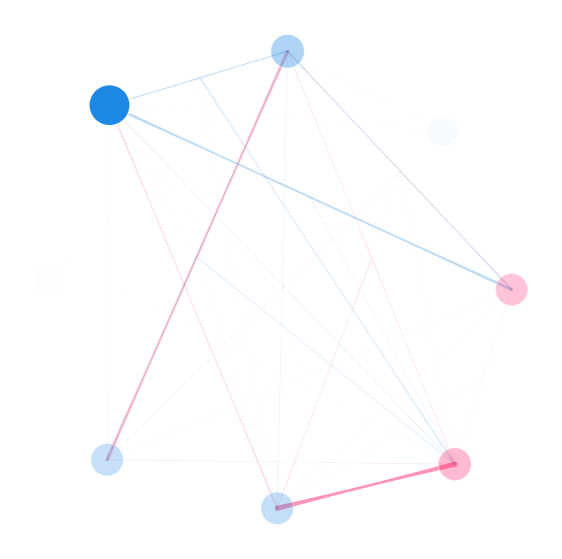

In [8]:
si = si_order[3]
graph = si.plot_si_graph(show=False)

By default, nodes are drawn in a circular layout and the player's indices used as their names. Interactions of more than 2 players are shown using hyper-edges, see the interaction (0, 6, 7). The node size, color and opacity encode the importance of the main effect, see 5 for an example of a high negative impact. 

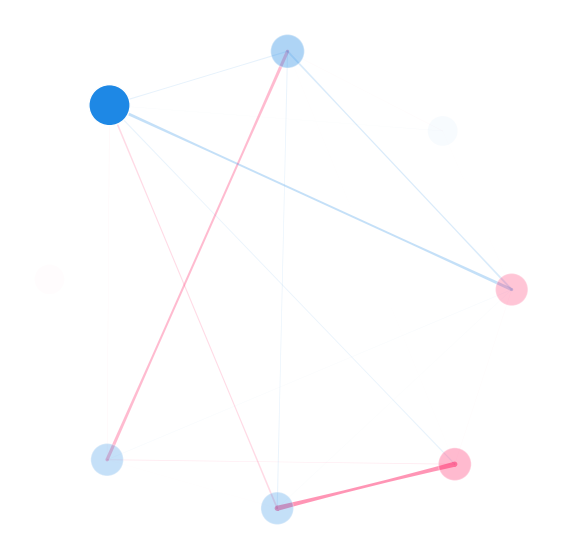

In [9]:
si.plot_network()

## Customizing with feature names and images
 


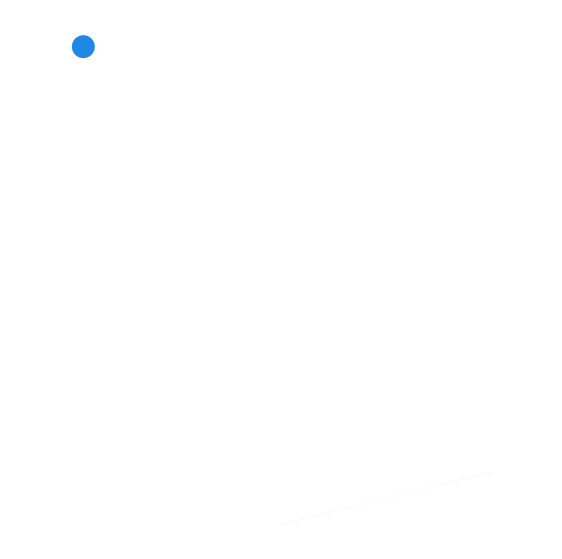

In [15]:
feature_names = list(x_data.columns)  # get the feature names
si.plot_si_graph(
    # names are accessed by their indices
    feature_names=feature_names,
    # images as well
    #img_patches = 
    # the image size is customizable
    #img_patch_size = ... 
)

## Inserting a known graph structure
Some datasets have an inherent graph structure. To integrate these relations, we can provide a graph either as an edge list or as a nx.Graph instance. Instead of the explanation nodes, we can adjust the layout using ``plot_original_nodes``, which displays nodes as white circles with their labels inside. Large primary effects will show as a halo around them. To allow easy comparison, it is also possible to plot the graph without the explanation graph. 

## Scaling the graph
Depending on the plot, it might be useful to change the scaling. SI plot provides several parameters to do so.
 ``size_factor`` allows to scale all explanations. For explanations that with smaller interactions, a value higher than one makes the interactions larger. A value below 1.0 scales them down. The default is 1.0. 
 If the nodes do not seem to fit, their values can be explicitly scaled with ``node_size_scaling`` (or changed from being represented by the area of the nodes to their radius with node_area_scaling.)
 If some of the hyper-edges overlap, try adjusting the ``compactness`` value to allow the graph to position them more freely.



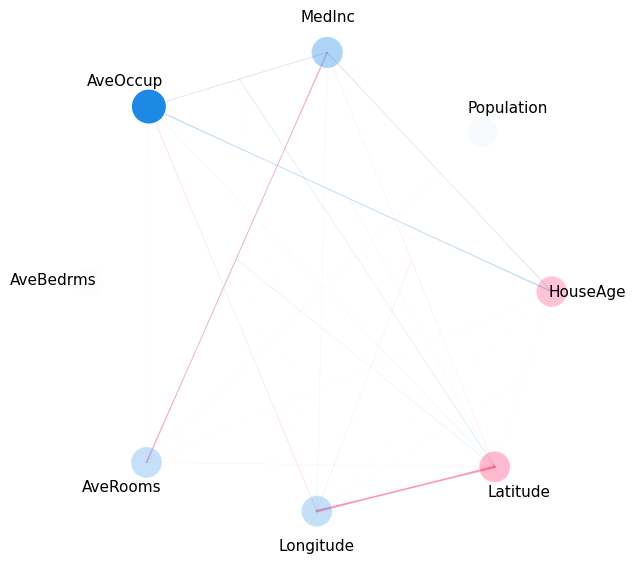

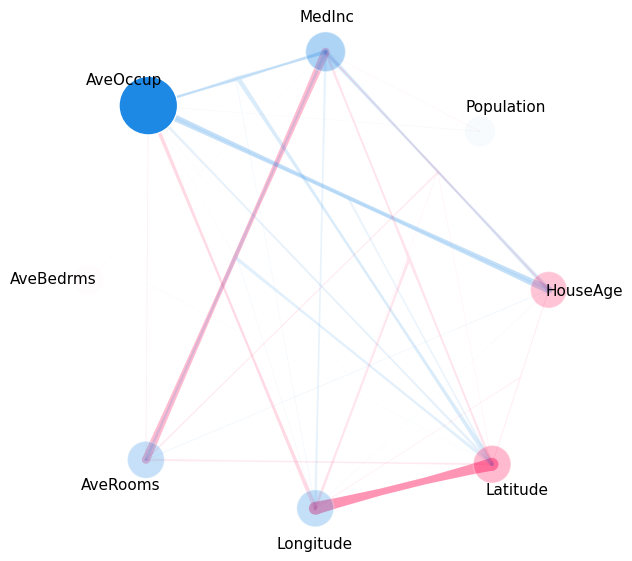

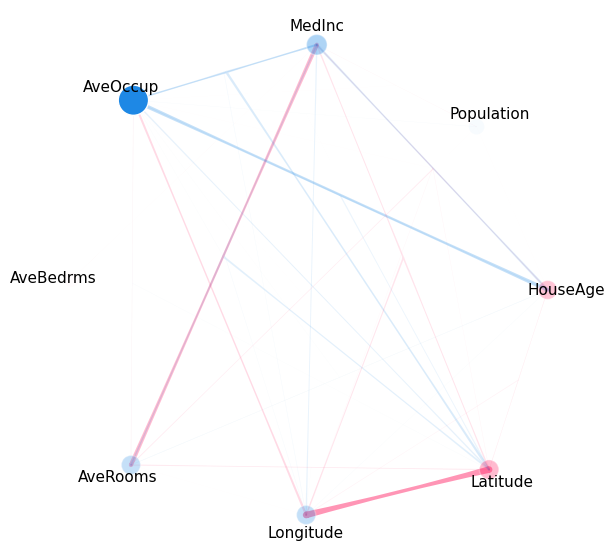

In [11]:
si.plot_si_graph(
    feature_names=feature_names, size_factor=0.5
)
si.plot_si_graph(
    feature_names=feature_names, size_factor=2.5
)
si.plot_si_graph(
    feature_names=feature_names, size_factor=2.5, node_size_scaling = 0.5
)

To put more emphasis on larger interactions, the scaling can be changed from linear to cubic scaling with cubic_scaling. (With minimum and maximum interactions, the scaling maximum and minimum can be set manually. )



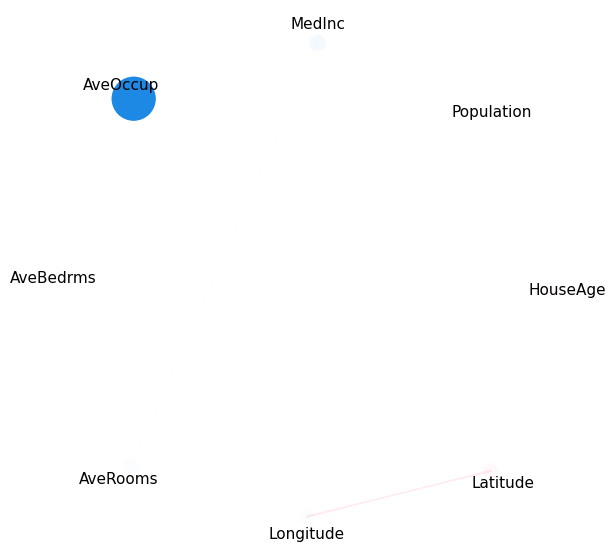

In [12]:
si.plot_si_graph(
    feature_names=feature_names, size_factor=5.0, node_size_scaling = 0.5, cubic_scaling = True
)

Other options to put focus on specific interactions is adjusting the draw_threshold or only visualize the interactions with the highest (absolute) values. We can filter to only show negative/positive interactions with interaction_direction: 

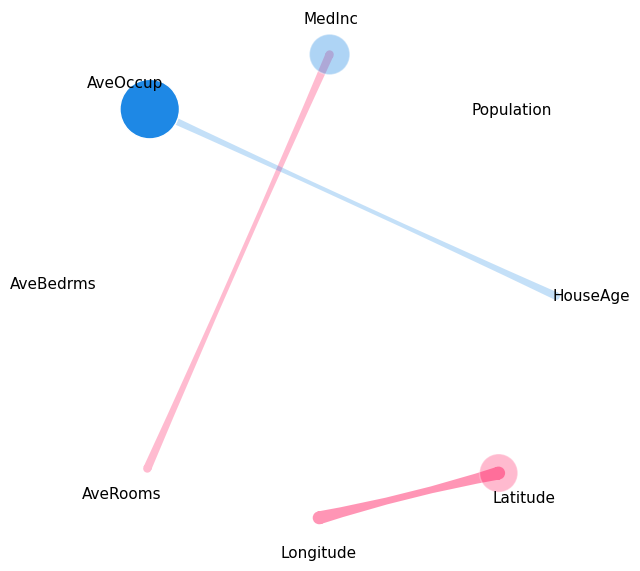

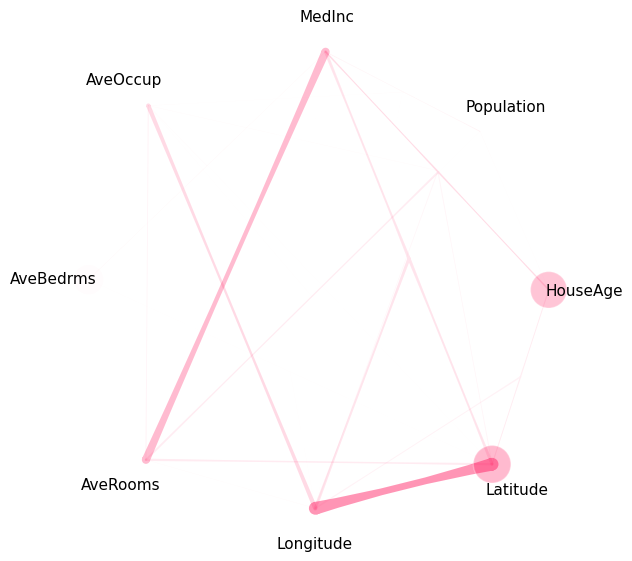

In [13]:
si.plot_si_graph(
    feature_names=feature_names, size_factor=2.5, 
    n_interactions = 7
), 
si.plot_si_graph(
    feature_names=feature_names, size_factor=2.5, 
    interaction_direction = 'positive'
)

In [ ]:
# example

Similar, if we want the nodes to have fixed positions we can specify them manually. 



In [ ]:
# example

Fine-tuning of the structure is also possible with compactness (scaling factor of the spring layout) and the spring constant (spring_k).